In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import unicodedata
import string
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
def findFiles(path): return glob.glob(path)
# path = 'gender/classes/*.txt'
path = 'data/names/*.txt'
print(findFiles(path))

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


In [3]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(path):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

Slusarski


In [4]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(lineToTensor('_'))

print(lineToTensor('Jones').size())

tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  1.]]])
torch.Size([5, 1, 57])


In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [6]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [7]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.7997, -2.9524, -2.9192, -2.8945, -2.9566, -2.9738, -2.9380,
         -2.8482, -2.8290, -2.8204, -2.9270, -2.9131, -2.8695, -2.7746,
         -2.8980, -2.7963, -2.9894, -2.9655]])


In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Portuguese', 13)


In [9]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Russian / line = Galdus
category = Dutch / line = Venn
category = Portuguese / line = D'cruze
category = English / line = Ferguson
category = Greek / line = Comino
category = Japanese / line = Narita
category = Korean / line = San
category = Japanese / line = Sugase
category = Russian / line = Onkov
category = Irish / line = Sheehy


In [10]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [11]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.3038 Cho / Vietnamese ✗ (Korean)
10000 10% (0m 15s) 2.1400 Foley / German ✗ (English)
15000 15% (0m 21s) 3.7146 Adam / Arabic ✗ (French)
20000 20% (0m 28s) 1.2676 Okano / Japanese ✓
25000 25% (0m 34s) 0.7102 Troinitsky / Russian ✓
30000 30% (0m 43s) 3.2699 Kwang  / Polish ✗ (Korean)
35000 35% (0m 50s) 0.6194 Vanetchkin / Russian ✓
40000 40% (0m 58s) 1.2146 Vinh / Vietnamese ✓
45000 45% (1m 5s) 1.0625 Tsuruga / Japanese ✓
50000 50% (1m 13s) 2.8572 Maneates / Dutch ✗ (Greek)
55000 55% (1m 20s) 0.4667 Seo / Korean ✓
60000 60% (1m 28s) 2.5798 Specht / German ✗ (Dutch)
65000 65% (1m 35s) 0.9372 Staska / Polish ✗ (Czech)
70000 70% (1m 42s) 2.4233 Kelly / English ✗ (Irish)
75000 75% (1m 51s) 1.5438 Roma / Spanish ✓
80000 80% (2m 0s) 1.9010 Pan / Vietnamese ✗ (Chinese)
85000 85% (2m 8s) 1.0582 San / Korean ✓
90000 90% (2m 18s) 2.1875 Teufel / Czech ✗ (German)
95000 95% (2m 26s) 3.8642 Eustis / Greek ✗ (French)
100000 100% (2m 34s) 1.7756 Sneiders / Portuguese ✗ (Dutch)


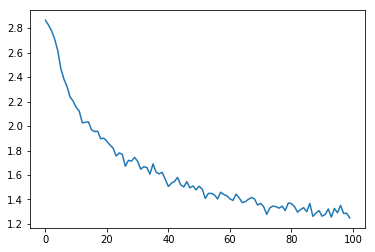

In [12]:
plt.figure()
plt.plot(all_losses)

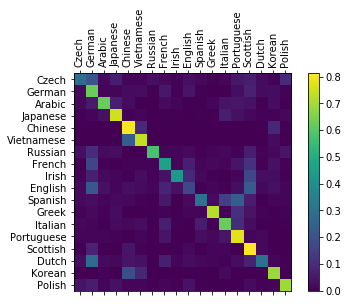

In [13]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [14]:
def predict(input_line, n_predictions=2):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        tot = 0
        for res in output[0]:
            tot += math.e**float(res.item())
        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            prob = math.e**(value)/tot
            print('(%.2f) %s' % (prob, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

for name in ['Lapo','Csenge','Lelle','Cosimo','Luca','Istvan','Paola','Reka']:
    predict(name)



> Lapo
(0.50) Portuguese
(0.15) Italian

> Csenge
(0.27) English
(0.21) French

> Lelle
(0.33) English
(0.21) Scottish

> Cosimo
(0.65) Portuguese
(0.10) Italian

> Luca
(0.34) Vietnamese
(0.26) Portuguese

> Istvan
(0.35) German
(0.22) English

> Paola
(0.46) Spanish
(0.13) Italian

> Reka
(0.42) Polish
(0.24) Czech
